### Import Statements

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Load the dataset

In [4]:
train = pd.read_csv('../data/train_processed.csv', low_memory=False, index_col='Date')
test = pd.read_csv('../data/test_processed.csv', low_memory=False, index_col='Id')

### Start Modeling

- Isolate single store data

In [6]:
train['Date'] = pd.to_datetime(train['Date.1'])
data = train[['Date', 'Store', 'Sales']]

# Filter for a specific store (e.g., Store 1)
store_data = data[data['Store'] == 1]
store_data.set_index('Date', inplace=True)
store_data = store_data.resample('D').sum()

- Autocorrelation and Partial Autocorrelation Analysis

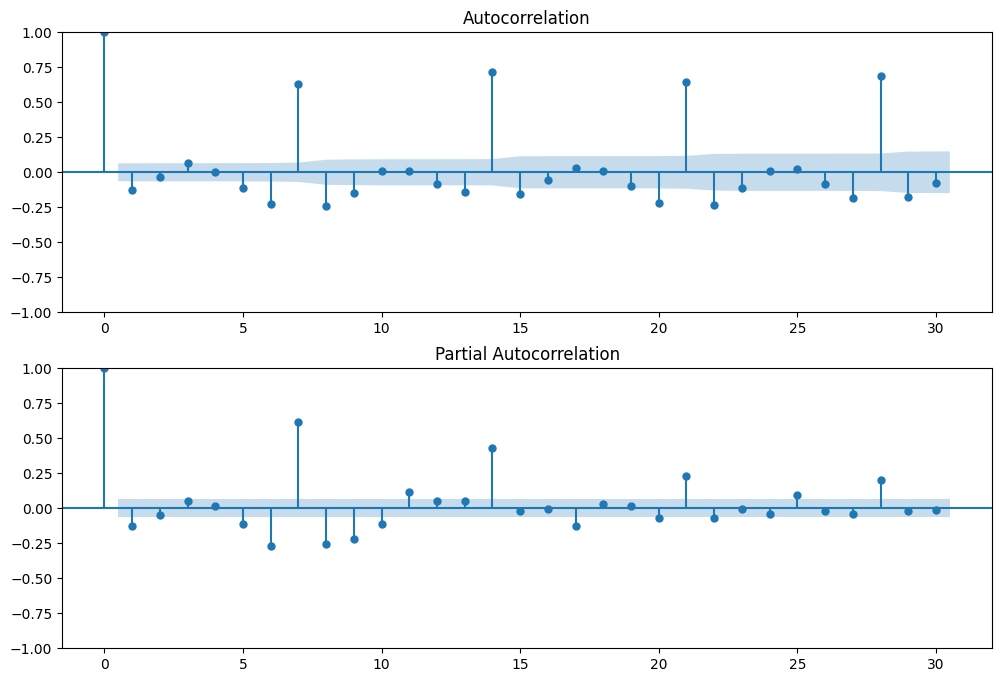

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(store_data['Sales'].dropna(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(store_data['Sales'].dropna(), lags=30, ax=ax[1])
plt.show()

-  Transform Data into Supervised Learning (Sliding Window)

In [9]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [10]:
# Define time steps
time_step = 10
data_scaled = MinMaxScaler(feature_range=(-1, 1)).fit_transform(store_data['Sales'].values.reshape(-1, 1))
X, y = create_dataset(data_scaled, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

- Scale the Data LSTMs perform better when the data is scaled to a range like (-1, 1).

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(store_data['Sales'].values.reshape(-1, 1))

# Create dataset for LSTM
X, y = create_dataset(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

- Build LSTM model

In [12]:
model = Sequential()
model.add(Input(shape=(time_step, 1)))  # Define the input shape
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
# Fit the model and store the history
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1923 - val_loss: 0.1640
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1812 - val_loss: 0.1561
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1803 - val_loss: 0.1563
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1886 - val_loss: 0.1541
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1768 - val_loss: 0.1543
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1938 - val_loss: 0.1592
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1858 - val_loss: 0.1532
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1674 - val_loss: 0.1527
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1814 - val_loss: 0.1597
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1739 - val_loss: 0.1525
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1722 - val_loss: 0.1522
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.19

### Evaluate the model

- Predict using the model

In [13]:
predicted_sales = model.predict(X)

# Inverse transform to get actual sales values
predicted_sales = scaler.inverse_transform(predicted_sales.reshape(-1, 1))

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


- Visualize the predictions

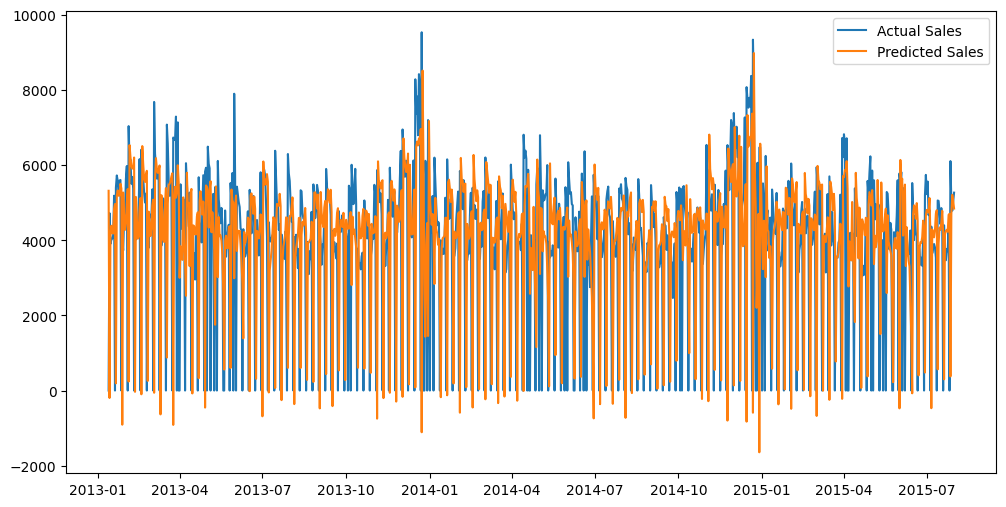

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(store_data.index[time_step+1:], store_data['Sales'][time_step+1:], label='Actual Sales')
plt.plot(store_data.index[time_step+1:], predicted_sales, label='Predicted Sales')
plt.legend()
plt.show()

- Numerically evaluate the model

In [15]:
mae = mean_absolute_error(store_data['Sales'][time_step+1:], predicted_sales)
mse = mean_squared_error(store_data['Sales'][time_step+1:], predicted_sales)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 1885.264597946085
Mean Squared Error (MSE): 7760058.705335244
Root Mean Squared Error (RMSE): 2785.6881924104937
